In [1]:
import numpy as np
import pandas as pd

from utils import nan_gmean, METATHERIAN_ORDERS

In [2]:
# Load the data from the UN FAO DAD-IS DB
# Domestic Animal Diversity Information System (DAD-IS)
anage_df = pd.read_csv('../data/112321_anage_data.txt', sep='\t', index_col=0)

# Up-front: remove organisms that are not mammals.
mask = anage_df.Class == 'Mammalia'
anage_df = anage_df[mask]

anage_df.columns.tolist()

['Kingdom',
 'Phylum',
 'Class',
 'Order',
 'Family',
 'Genus',
 'Species',
 'Common name',
 'Female maturity (days)',
 'Male maturity (days)',
 'Gestation/Incubation (days)',
 'Weaning (days)',
 'Litter/Clutch size',
 'Litters/Clutches per year',
 'Inter-litter/Interbirth interval',
 'Birth weight (g)',
 'Weaning weight (g)',
 'Adult weight (g)',
 'Growth rate (1/days)',
 'Maximum longevity (yrs)',
 'Source',
 'Specimen origin',
 'Sample size',
 'Data quality',
 'IMR (per yr)',
 'MRDT (yrs)',
 'Metabolic rate (W)',
 'Body mass (g)',
 'Temperature (K)',
 'References']

In [3]:
cols2count = ['Gestation/Incubation (days)',
 'Weaning (days)',
 'Litter/Clutch size',
 'Litters/Clutches per year',
 'Inter-litter/Interbirth interval',
 'Birth weight (g)',
 'Weaning weight (g)',
 'Adult weight (g)',
 'Growth rate (1/days)',
 'Maximum longevity (yrs)',
 'IMR (per yr)',
 'MRDT (yrs)',
 'Metabolic rate (W)',
 'Body mass (g)',
 'Temperature (K)']

for c in cols2count:
    print(c, (anage_df[c] > 0).sum())

Gestation/Incubation (days) 1024
Weaning (days) 810
Litter/Clutch size 1232
Litters/Clutches per year 813
Inter-litter/Interbirth interval 656
Birth weight (g) 849
Weaning weight (g) 405
Adult weight (g) 1310
Growth rate (1/days) 250
Maximum longevity (yrs) 1012
IMR (per yr) 15
MRDT (yrs) 17
Metabolic rate (W) 422
Body mass (g) 422
Temperature (K) 457


In [4]:
cols_of_interest = ['Gestation/Incubation (days)',
 'Weaning (days)',
 'Litter/Clutch size',
 'Litters/Clutches per year',
 'Inter-litter/Interbirth interval',
 'Birth weight (g)',
 'Weaning weight (g)',
 'Adult weight (g)',
 'Growth rate (1/days)',
 'Maximum longevity (yrs)',
 'IMR (per yr)',
 'MRDT (yrs)',
 'Metabolic rate (W)',
 'Body mass (g)',
 'Temperature (K)']

# Zero values are non-sensical - should be NaN for log-scale plotting
for c in cols_of_interest:
    mask = anage_df[c] == 0
    anage_df.loc[mask, c] = np.nan
    
# Drop everything that is missing data in all columns of interest. 
anage_df = anage_df.dropna(axis=0, how='all', subset=cols_of_interest)
anage_df['Binomial Name'] = anage_df.Genus.str.strip(' ') + " " + anage_df.Species.str.strip(' ')

# Mark the placental mammals, i.e. not monotremes or marsupials
anage_df['PlacentalMammal'] = ~anage_df['Order'].isin(METATHERIAN_ORDERS)

# Convert longevity data to months units to match AnAge
anage_df['Maximum longevity (months)'] = 12*anage_df['Maximum longevity (yrs)']
    
# Calculate the number of young per year from the litter size and interval between litters.
litter_size = anage_df['Litter/Clutch size']

# Anage gives two values that can be used to infer litters/year.
# 1/ Litters per year and 2/ Inter-litter interval
# As can be seen in the plot below, these values are correlated but not the same.
# Moreover, in some cases there is data for one and not the other.
litters_per_year = anage_df['Litters/Clutches per year']
interbirth_interval_d = anage_df['Inter-litter/Interbirth interval']
litters_per_year_inferred = 365.0/interbirth_interval_d
young_per_year_litters = litter_size / litters_per_year
young_per_year_interval = litter_size / litters_per_year_inferred

anage_df['YoungPerYear_Litters'] = young_per_year_litters
anage_df['YoungPerYear_Interval'] = young_per_year_interval

gmeans = pd.concat([young_per_year_litters, young_per_year_interval], axis=1).apply(nan_gmean, axis=1)
anage_df['YoungPerYear_Estimated'] = gmeans

neonate_mass_g = anage_df['Birth weight (g)']
anage_df['YoungMassPerYear_Estimated (g)'] = neonate_mass_g*gmeans

# remove the lower-quality data from the cleaned dataset
quality_mask = anage_df['Data quality'].isin('acceptable,high'.split(','))
anage_clean_df = anage_df[quality_mask].copy()

# Save a new cleaner file with units for the relevant columns.
anage_clean_df.to_csv('../data/112321_AnAge_cleaned.csv')
anage_clean_df.shape

(990, 37)

In [5]:
from matplotlib import pyplot as plt 
import seaborn as sns

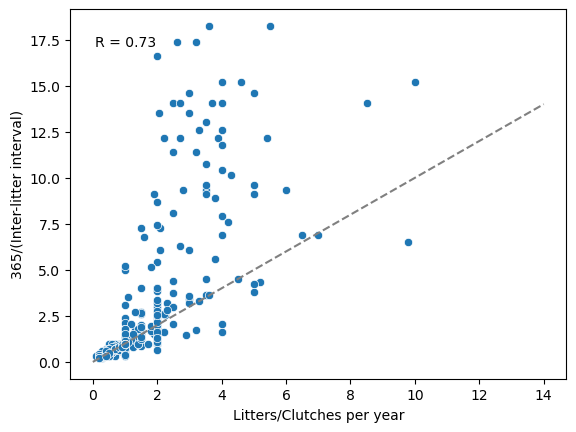

In [6]:
# Check consistency of the two columns reporting on litter frequency
mask = np.logical_and(anage_clean_df['Litters/Clutches per year'].notnull(),
                      anage_clean_df['Inter-litter/Interbirth interval'].notnull())
sub_df = anage_clean_df[mask]
x, y = sub_df['Litters/Clutches per year'], 365.0/sub_df['Inter-litter/Interbirth interval']

fig, ax = plt.subplots()
plt.scatter(x, y, linewidth=0.5, edgecolor='w')
plt.plot(np.arange(15), np.arange(15), ls='--', color='grey')
r = np.corrcoef(x, y)[0,1]
plt.text(0.05, 0.9, "R = {0:.2f}".format(r), transform=ax.transAxes)
plt.xlabel('Litters/Clutches per year')
plt.ylabel('365/(Inter-litter interval)')

plt.show()

# Looks like the inter-litter interval is more like the minimum inter-litter interval,
# since it pretty consistently gives high litters-per-year than the reported value. 

In [7]:
anage_clean_df.Class.unique()

array(['Mammalia'], dtype=object)